# Exploratory Analysis 


<div class="alert alert-info">
    <strong>This notebook depicts analysis about  </strong>
    <ul>
       <ul>
           <li>Case 1: How often must the device connection be re-  established</li>
           <li>Case 2: How long is the device disconnected</li>
        </ul>
</div>



**To go over this analysis, we will use <span style="font-family: Arial, Helvetica, sans-serif;">tunnel_service_data.csv </span> dataset**
- it contains information about tunnel.service messages with respect to machine id
- we want to know if we can analyse case 1 and case 2


In [2]:
import pandas as pd
import re
from datetime import datetime  
import pytz  # Import the pytz module for time zone handling
import matplotlib.pyplot as plt
from tabulate import tabulate

**Let's read the data and make some exploratory analysis**

In [3]:
# Load the CSV file into a Pandas DataFrame
csv_data_path = '../data/tunnel_service_data.csv'
tunnel_data_df = pd.read_csv(csv_data_path)

# Convert timestamps to CET
def convert_to_cet(timestamp):
    # Assuming the timestamps are in microseconds
    timestamp /= 1000000  # Convert to seconds
    utc_datetime = datetime.utcfromtimestamp(timestamp)
    cet_timezone = pytz.timezone('CET')
    cet_datetime = utc_datetime.replace(tzinfo=pytz.utc).astimezone(cet_timezone)
    return cet_datetime

# Apply the conversion to the "TIMESTAMP" column
tunnel_data_df['TIMESTAMP'] = tunnel_data_df['TIMESTAMP'].apply(convert_to_cet)

#prints the dataframe
tunnel_data_df.head()

,MACHINE_ID,TIMESTAMP,MESSAGE,ERROR
0,224d1cf88daf44b8a20734f479a0f5ed,2023-03-02 14:03:42.378466+01:00,Started SmartWireless Tunnel Daemon.,NaN
1,224d1cf88daf44b8a20734f479a0f5ed,2023-03-02 14:03:43.801231+01:00,config server_addr: smartconnect.smartwireles...,NaN
2,224d1cf88daf44b8a20734f479a0f5ed,2023-03-02 14:03:43.801231+01:00,tls_crt: /data/factory_settings/ssl/moco.crt,NaN
3,224d1cf88daf44b8a20734f479a0f5ed,2023-03-02 14:03:43.801231+01:00,tls_key: /data/factory_settings/ssl/moco.key,NaN
4,224d1cf88daf44b8a20734f479a0f5ed,2023-03-02 14:03:43.801231+01:00,root_ca: /data/factory_settings/ssl/smartconne...,NaN


**We are interested in the tunnel service write messages, specifically:**
- for the start: "action start"
- for the establishment of a connection: "action dial"
- for the successful establishment: "action handshake" 
- for the termination of the connection: "action disconnected"

**So initially let's look at some basic statistics present in the MESSAGE concerning our interest. Please note that we are not handling NaN present in the ERROR column since it is not relevant at this point**


In [4]:
# List of action types to count
action_types = ['start', 'dial', 'handshake', 'disconnected']

# Initialize a dictionary to store counts for each action type
action_counts = {}

# Loop through each action type and count occurrences
for action in action_types:
    # Create a boolean mask for the current action type and sum the occurrences
    count = tunnel_data_df['MESSAGE'].str.contains(f'action {action}').sum()
    # Store the count in the dictionary
    action_counts[f'action {action}'] = count

# the counts for each action type in a tabular format
table = []
for action, count in action_counts.items():
    table.append([action, count])

headers = ['Action Type', 'Count']
print(tabulate(table, headers=headers, tablefmt='grid'))

+---------------------+---------+
| Action Type         |   Count |
+=====================+=========+
| action start        |      76 |
+---------------------+---------+
| action dial         |    1517 |
+---------------------+---------+
| action handshake    |      84 |
+---------------------+---------+
| action disconnected |      74 |
+---------------------+---------+


**The initial statistics indicate the individual count of every action message. Let's move on to case specific analysis. We shall look at the first case**

**_How often must the device connection be re-established?_**

- To figure out this, we have to calculate the instances of 'action dial' counts occuring between each 'action disconnected' state and 'action handshake' state

In [5]:
# Initialize variables to keep track of the current connection
in_disconnected_phase = False
dial_count = 0
error_messages = []
machine_id = None
action_disconnected_timestamp = None
action_handshake_timestamp = None
total_dial_count = 0  # Variable to store total ACTION DIAL counts
dial_counts = []
time_durations = []

# regex patterns for the actions
action_disconnected_pattern = re.compile(r'action disconnected')
action_dial_pattern = re.compile(r'action dial')
action_handshake_pattern = re.compile(r'action handshake')

# Initialize an index variable
index_number = 1

# Iterate through the DataFrame
for index, row in tunnel_data_df.iterrows():
    message = row["MESSAGE"]
    if action_disconnected_pattern.search(message):
        
        in_disconnected_phase = True
        error_messages = []
        machine_id = row["MACHINE_ID"]
        action_disconnected_timestamp = row["TIMESTAMP"]

    elif in_disconnected_phase:
        if action_dial_pattern.search(message):
            dial_count += 1
        elif action_handshake_pattern.search(message):
            # Count this disconnection as one instance of re-establishing
            action_handshake_timestamp = row["TIMESTAMP"]

            # Update the total ACTION DIAL counts
            total_dial_count += dial_count
            time_duration = (action_handshake_timestamp - action_disconnected_timestamp).total_seconds()
            time_durations.append(time_duration)
            dial_counts.append(dial_count)
          
            # Print the details with the index
            print(f"Item: {index_number}")
            print(f"Machine ID: {machine_id}")
            print(f"Action Disconnected Timestamp: {action_disconnected_timestamp}")
            print(f"Action Handshake Timestamp: {action_handshake_timestamp}")
            print(f"Number of re-establishment attempts: {dial_count}")
            for i, error_message in enumerate(error_messages):
                print(f"Error {i+1}: {error_message}")
            print("")

            dial_count = 0  # Reset the dial count for the next instance
            index_number += 1  # Increment the index

        elif not pd.isna(row['ERROR']):
            error_messages.append(row['ERROR'])

# Print the total ACTION DIAL counts
print(f"Total number of re-establishment attempts: {total_dial_count}")


Item: 1
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-02 16:03:40.041539+01:00
Action Handshake Timestamp: 2023-03-02 16:03:41.098148+01:00
Number of re-establishment attempts: 1

Item: 2
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-02 16:03:40.041539+01:00
Action Handshake Timestamp: 2023-03-03 14:07:35.169799+01:00
Number of re-establishment attempts: 1
Error 1: MESSAGE= level 1 action start

Item: 3
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-08 03:26:00.485292+01:00
Action Handshake Timestamp: 2023-03-08 03:26:25.424444+01:00
Number of re-establishment attempts: 3
Error 1: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 2: MESSAGE=failed to start tunnels: failed to connect to server: backoff limit exeded: dial tcp: i/o timeout
Error 3: MESSAGE=tunnel.service: Failed with result 'exit-code'.
Error 4:

Item: 31
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-06-07 01:58:24.007776+02:00
Action Handshake Timestamp: 2023-06-07 13:00:34.636229+02:00
Number of re-establishment attempts: 1022
Error 1: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 2: MESSAGE=failed to start tunnels: failed to connect to server: backoff limit exeded: dial tcp: i/o timeout
Error 3: MESSAGE=tunnel.service: Failed with result 'exit-code'.
Error 4: MESSAGE= level 1 action start
Error 5: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 6: MESSAGE= level 1 action backoff sleep 552.330144ms
Error 7: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 8: MESSAGE= level 1 action backoff sleep 1.080381816s
Error 9: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwir

Item: 56
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-07-24 14:24:56.913520+02:00
Action Handshake Timestamp: 2023-07-24 14:36:40.846353+02:00
Number of re-establishment attempts: 21
Error 1: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 2: MESSAGE=failed to start tunnels: failed to connect to server: backoff limit exeded: dial tcp: i/o timeout
Error 3: MESSAGE=tunnel.service: Failed with result 'exit-code'.
Error 4: MESSAGE= level 1 action start
Error 5: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 6: MESSAGE= level 1 action backoff sleep 552.330144ms
Error 7: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwireless.de:5225 err dial tcp: i/o timeout
Error 8: MESSAGE= level 1 action backoff sleep 1.080381816s
Error 9: MESSAGE= level 0 msg dial failed network tcp addr smartconnect.smartwirel

<div class="alert alert-success">
    <strong>From the above cell we can witness:</strong>
    <ul>
        <li>the number of re-establishment attempts between each disconnect and connect instance.</li>
        <li>the error messages present under tunnel.service.</li>
        <li>the total number of re-establishment attempts are 1515. We see a difference of 2 in the total number of re-establishment attempts, which indicates the presence of establishment messages occurred before the first disconnect.</li>
    </ul>
</div>


**Lets visualise the result**

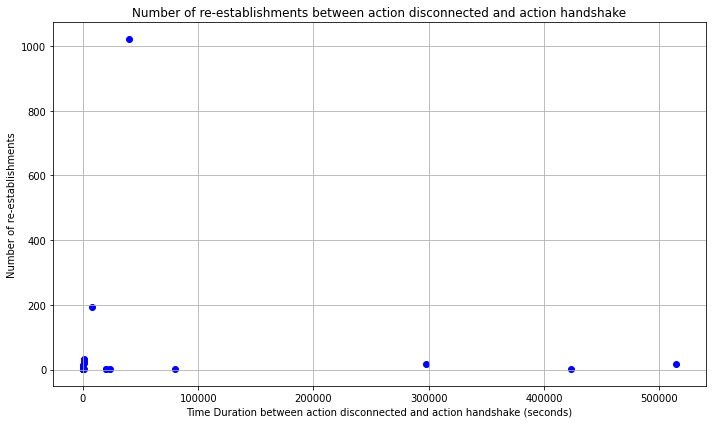

In [7]:
# a scatter plot with time duration on the x-axis and action dial counts on the y-axis
plt.figure(figsize=(10, 6))

# Plot the scatter points
plt.scatter(time_durations, dial_counts, color='b', marker='o')

plt.xlabel('Time Duration between action disconnected and action handshake (seconds)')
plt.ylabel('Number of re-establishments')
plt.title('Number of re-establishments between action disconnected and action handshake')
plt.grid(True)
plt.tight_layout()
plt.show()


<div class="alert alert-success">
    <strong>From the scatter plot we can observe:</strong>
    <ul>
        <li>the minimum number of re-establishment attempt is 1 for obvious reasons, and the maximum number of attempts is 1021</li>
        <li>a huge concentration of re-establishment counts close to 50 with a significantly lesser time interval between disconnect and connect</li>
        <li>the plot also indicates the presence of outliers, i.e.,</li>
        <ul>
            <li>the maximum number of attempts in one instance is 1021</li>
            <li>the maximum time duration between a successful connection is more than 50000 seconds</li>
        </ul>
    </ul>
</div>


**Now that we have seen the result of case 1, we move on to case 2**

**_How long is the device disconnected?_**

- To figure out this, we have to calculate the time duration between each 'action disconnected' state and 'action handshake' state

In [19]:
# Initialize variables to keep track of the current connection
in_disconnected_phase = False
action_disconnected_timestamp = None
action_handshake_timestamp = None
disconnection_durations = []

# regex patterns for the actions
action_disconnected_pattern = re.compile(r'action disconnected')
action_handshake_pattern = re.compile(r'action handshake')

# Lists to store data for the plot
x_labels = []  # Labels for x-axis
y_values = []  # Durations for y-axis

# Iterate through the DataFrame
for index, row in tunnel_data_df.iterrows():
    message = row["MESSAGE"]
    if action_disconnected_pattern.search(message):
        # Case 1: Connection is disconnected
        in_disconnected_phase = True
        action_disconnected_timestamp = pd.to_datetime(row["TIMESTAMP"])
        machine_id = row["MACHINE_ID"]
    elif in_disconnected_phase and action_handshake_pattern.search(message):
        # Case 2: Connection is re-established with action handshake
        in_disconnected_phase = False
        action_handshake_timestamp = pd.to_datetime(row["TIMESTAMP"])
        # Calculate the time duration between disconnected and handshake
        disconnection_duration = (action_handshake_timestamp - action_disconnected_timestamp).total_seconds()
        disconnection_durations.append(disconnection_duration)
        # label for the pair
        pair_label = f"Pair {len(x_labels) + 1}"
        x_labels.append(pair_label)
        y_values.append(disconnection_duration)
        # Print the details for each instance
        print(pair_label)
        print(f"Machine ID: {machine_id}")
        print(f"Action Disconnected Timestamp: {action_disconnected_timestamp}")
        print(f"Action Handshake Timestamp: {action_handshake_timestamp}")
        print(f"Disconnection Duration (seconds): {disconnection_duration}")
        print()

# Calculate and print the maximum, minimum, and average durations
if disconnection_durations:
    max_duration = max(disconnection_durations)
    min_duration = min(disconnection_durations)
    avg_duration = sum(disconnection_durations) / len(disconnection_durations)
    print(f"Maximum Disconnection Duration (seconds): {max_duration}")
    print(f"Minimum Disconnection Duration (seconds): {min_duration}")
    print(f"Average Disconnection Duration (seconds): {avg_duration}")
else:
    print("No disconnection durations found.")




Pair 1
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-02 16:03:40.041539+01:00
Action Handshake Timestamp: 2023-03-02 16:03:41.098148+01:00
Disconnection Duration (seconds): 1.056609

Pair 2
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-08 03:26:00.485292+01:00
Action Handshake Timestamp: 2023-03-08 03:26:25.424444+01:00
Disconnection Duration (seconds): 24.939152

Pair 3
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-09 13:10:38.683849+01:00
Action Handshake Timestamp: 2023-03-09 13:10:39.996733+01:00
Disconnection Duration (seconds): 1.312884

Pair 4
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-14 13:16:30.757976+01:00
Action Handshake Timestamp: 2023-03-14 13:16:31.568198+01:00
Disconnection Duration (seconds): 0.810222

Pair 5
Machine ID: 224d1cf88daf44b8a20734f479a0f5ed
Action Disconnected Timestamp: 2023-03-17 14:18:46.988521+01:00

<div class="alert alert-success">
    <strong>We observe how long is the device disconnected and how many such instances have occurred</strong>
    <ul>
        <li>we notice that the maximum disconnection duration is around 40000 seconds i.e. 11 hours</li>
        <li>we also see that the average disconnection duration is around 710 seconds i.e. approximately 12 minutes.</li>
    </ul>
</div>


**Lets visualise this using a bar chart**

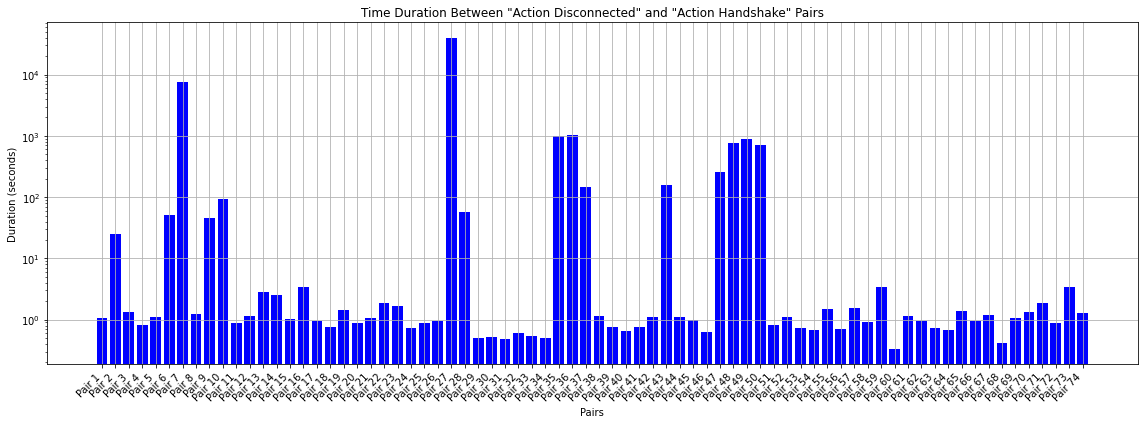

In [20]:
# a bar chart with a logarithmic y-axis
plt.figure(figsize=(16, 6))  # Adjust figure size
plt.bar(x_labels, y_values, color='blue')
plt.title('Time Duration Between "Action Disconnected" and "Action Handshake" Pairs')
plt.xlabel('Pairs')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yscale("log")  # logarithmic y-axis scale
plt.tight_layout()  
plt.grid(True)
plt.show()

<div class="alert alert-success">
    <strong>The graph depicts the time duration occurred between action disconnected and action handshake pairs</strong>
    <ul>
        <li>We see a big spike for the maximum duration in pair 27 almost close to 40000 seconds i.e. 11 hours</li>
    </ul>
</div>
